Lab 6: Variable Selection and Regularization

Dataset: Baseball Players
In this lab, we will use predictive modeling to design a model that predicts a baseball player’s salary in a given year.

This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
data= pd.read_csv('/content/Hitters.csv')
good_cols = data.isna().sum() < 100
data = data.loc[:,good_cols]
data = data.dropna()

#Part I: Different Model Specs


###A. Regression without regularization
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [3]:
X = data.drop(["Salary"], axis = 1)
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")

lr_pipeline_1.fit(X, y)
lr_pipeline_1.named_steps["linear_regression"].coef_


array([ -31.29971152,   31.29971152,   58.42462282,  -58.42462282,
         12.38116255,  -12.38116255, -291.0945557 ,  337.83047948,
         37.85383676,  -60.57247861,  -26.99498379,  135.07389695,
        -16.69335888, -391.03865466,   86.68761664,  -14.18172332,
        480.74713477,  260.68988581, -213.89225864,   78.76129639,
         53.73248973,  -22.16086217])

In [4]:
df= pd.DataFrame()
df["columns"]= ct.fit_transform(X).columns
df["coefficients"]= lr_pipeline_1.named_steps["linear_regression"].coef_
df.sort_values(by = "coefficients", key=abs, ascending = False)

,columns,coefficients
16,standardize__CRuns,480.747135
13,standardize__CAtBat,-391.038655
7,standardize__Hits,337.830479
6,standardize__AtBat,-291.094556
17,standardize__CRBI,260.689886
18,standardize__CWalks,-213.892259
11,standardize__Walks,135.073897
14,standardize__CHits,86.687617
19,standardize__PutOuts,78.761296
9,standardize__Runs,-60.572479


Interpret a few of them:
Cruns: this is the variable that changed the salary the most. It means that ofr each standard deviation above the average career hits your salary would increase by $480.
CAtBats: this is the second most important variable for predicting salary, its -391 coefficent means that each standard deviation you are above the mean at bat that ones salary would decrease by -391 dollars.
dummy variable division: Although it is not one of the most important variables its important to understand what this means. It means that if you are in the east division your salary is predicted to increase by 58 dollars. And if you in the west divsion your salary will decrease by 58 dollars.

In [5]:
cross=cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print(-cross)

121136.31031816891


###B. Ridge regression
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the
 hyperparameter.

Fit the pipeline with your chosen
 to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [6]:
X = data.drop(["Salary"], axis = 1)
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

rr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)
alpha = {'ridge_regression__alpha': [.001,.01,.1,1,10,100]}
rr = GridSearchCV(rr_pipeline, alpha, cv = 5, scoring='neg_mean_squared_error')
rr_fitted = rr.fit(X, y)
rresult=pd.DataFrame(data = {"alpha": [.001,.01,.1,1,10,100], "scores": -rr_fitted.cv_results_['mean_test_score']})
rresult.sort_values(by = "scores")

,alpha,scores
3,1.000,119144.432677
4,10.000,119348.984776
2,0.100,120343.621067
5,100.000,120716.435589
1,0.010,121022.903286
0,0.001,121124.458592


In [7]:
X = data.drop(["Salary"], axis = 1)
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

rr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]).set_output(transform = "pandas")
rr_fitted = rr_pipeline.fit(X, y)
df= pd.DataFrame()
df["columns"]= ct.fit_transform(X).columns
df["coefficients"]= rr_fitted.named_steps["ridge_regression"].coef_
df.sort_values(by = "coefficients", key=abs, ascending = False)

,columns,coefficients
16,standardize__CRuns,320.412169
7,standardize__Hits,296.645050
6,standardize__AtBat,-270.686441
13,standardize__CAtBat,-225.406548
18,standardize__CWalks,-184.423611
17,standardize__CRBI,160.386784
14,standardize__CHits,126.659607
11,standardize__Walks,124.407173
19,standardize__PutOuts,78.623656
3,dummify__Division_W,-60.015595


In [8]:
cross=cross_val_score(rr_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print(-cross)

119144.43267691585


###C. Lasso Regression
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the
 hyperparameter.

Fit the pipeline with your chosen
 to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [9]:
X = data.drop(["Salary"], axis = 1)
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso())]
).set_output(transform = "pandas")

alpha = {'lasso__alpha': [.001,.01,.1,1,10,100]}
lass = GridSearchCV(lasso_pipeline, alpha, cv = 5, scoring='neg_mean_squared_error')
lass_fitted = lass.fit(X, y)
lassresult=pd.DataFrame(data = {"alpha": [.001,.01,.1,1,10,100], "scores": -lass_fitted.cv_results_['mean_test_score']})
lassresult.sort_values(by = "scores")

,alpha,scores
3,1.000,119761.587407
2,0.100,120682.252637
1,0.010,120964.764686
0,0.001,120994.179815
4,10.000,121828.141333
5,100.000,143755.162381


In [12]:
X = data.drop(["Salary"], axis = 1)
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso(alpha=1))]
).set_output(transform = "pandas")

lass_fitted = lasso_pipeline.fit(X, y)
df= pd.DataFrame()
df["columns"]= ct.fit_transform(X).columns
df["coefficients"]= lass_fitted.named_steps["lasso"].coef_
df.sort_values(by = "coefficients", key=abs, ascending = False)

,columns,coefficients
16,standardize__CRuns,3.755655e+02
7,standardize__Hits,3.043595e+02
6,standardize__AtBat,-2.823710e+02
17,standardize__CRBI,1.926109e+02
18,standardize__CWalks,-1.896446e+02
13,standardize__CAtBat,-1.626398e+02
11,standardize__Walks,1.206953e+02
2,dummify__Division_E,1.144130e+02
19,standardize__PutOuts,7.876037e+01
20,standardize__Assists,4.199668e+01


In [13]:
cross=cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print(-cross)

119761.58740741308


###D. Elastic Net
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the
 and
 hyperparameters.

Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [14]:
X = data.drop(["Salary"], axis = 1)
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

elas_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic", ElasticNet())]
).set_output(transform = "pandas")

alphas = {'elastic__alpha': [.001,.01,.1,1,10,100],
           'elastic__l1_ratio': [.1,.2,.4,.5,.6,.8,.9]}

elas = GridSearchCV(elas_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
elas_fitted = elas.fit(X, y)
elas_fitted.cv_results_['params']
params_df = pd.DataFrame(elas_fitted.cv_results_['params'])
results_df = params_df.assign(scores=elas_fitted.cv_results_['mean_test_score'])
results_df.sort_values(by='scores', ascending=False)

,elastic__alpha,elastic__l1_ratio,scores
20,0.100,0.9,-118969.493401
7,0.010,0.1,-118973.789477
19,0.100,0.8,-118994.427874
8,0.010,0.2,-118995.938080
9,0.010,0.4,-119067.258302
10,0.010,0.5,-119123.793086
11,0.010,0.6,-119204.240814
18,0.100,0.6,-119258.769435
17,0.100,0.5,-119381.375571
16,0.100,0.4,-119496.298540


In [16]:
X = data.drop(["Salary"], axis = 1)
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

elas_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic", ElasticNet(alpha=.1, l1_ratio=.9))]
).set_output(transform = "pandas")

elas_fitted = elas_pipeline.fit(X, y)
df= pd.DataFrame()
df["columns"]= ct.fit_transform(X).columns
df["coefficients"]= elas_fitted.named_steps["elastic"].coef_
df.sort_values(by = "coefficients", key=abs, ascending = False)

,columns,coefficients
7,standardize__Hits,247.556146
6,standardize__AtBat,-231.507812
16,standardize__CRuns,223.037490
18,standardize__CWalks,-154.668829
17,standardize__CRBI,121.693430
14,standardize__CHits,120.015425
13,standardize__CAtBat,-115.293711
11,standardize__Walks,110.808235
19,standardize__PutOuts,77.918539
3,dummify__Division_W,-60.671749


In [17]:
cross=cross_val_score(elas_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print(-cross)

118969.49340131154


#Part II. Variable Selection
Based on the above results, decide on:

Which numeric variable is most important.

Which five numeric variables are most important

Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

Using only the one best numeric variable.

Using only the five best variables.

Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note:  labmda and alpha must be re-tuned for each feature set.)

Using the elastic model since it has the smallest MSE

1) the numeric variable that is the most important is hits

2) the five most important variables are standardized hits, at bats, career runs, careers walks, and career hits.

3) division is the most important categorical varaible.

Now for all model specifications

###linear regression

1. one variable

In [18]:
X = data[["Hits"]]
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")

lr_pipeline_1.fit(X, y)
cross1=cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 1",-cross1)

model 1 173088.97286444032


2. 5 variables

In [19]:
X = data[["Hits","AtBat", "CRuns","CWalks","CHits"]]
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")

lr_pipeline_1.fit(X, y)
cross2=cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 2",-cross2)

model 2 127818.20009326501


3. 5 variable interaction

In [20]:
X = data[["Hits","AtBat", "CRuns","CWalks","CHits", "Division"]]
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__AtBat", "dummify__Division_W"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__AtBat", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_E"]),
    ("interaction6", PolynomialFeatures(interaction_only = True), ["standardize__CWalks", "dummify__Division_W"]),
    ("interaction7", PolynomialFeatures(interaction_only = True), ["standardize__CWalks", "dummify__Division_E"]),
    ("interaction8", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_W"]),
    ("interaction9", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_E"])
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
   ("interaction",ct_inter),
  ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")

lr_pipeline_1.fit(X, y)
cross3=cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 3",-cross3)

model 3 131736.99148430483


###Ridge regression

most important

In [21]:
X = data[["Hits"]]
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

rr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)
alpha = {'ridge_regression__alpha': [.001,.01,.1,1,10,100]}
rr = GridSearchCV(rr_pipeline, alpha, cv = 5, scoring='neg_mean_squared_error')

rr_fitted = rr.fit(X, y)
rresult=pd.DataFrame(data = {"alpha": [.001,.01,.1,1,10,100], "scores": -rr_fitted.cv_results_['mean_test_score']})
rresult.sort_values(by = "scores")

,alpha,scores
4,10.000,172755.975523
3,1.000,173046.230311
2,0.100,173084.595954
1,0.010,173088.534138
0,0.001,173088.928981
5,100.000,174448.308656


In [22]:
rr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=10))]
).set_output(transform = "pandas")

rr_fitted = rr_pipeline.fit(X, y)
cross4=cross_val_score(rr_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 4",-cross4)

model 4 172755.97552343184


5 variables

In [23]:
X = data[["Hits","AtBat", "CRuns","CWalks","CHits"]]
y = data["Salary"]

rr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)
alpha = {'ridge_regression__alpha': [.001,.01,.1,1,10,100]}
rr = GridSearchCV(rr_pipeline, alpha, cv = 5, scoring='neg_mean_squared_error')
rr_fitted = rr.fit(X, y)
rresult=pd.DataFrame(data = {"alpha": [.001,.01,.1,1,10,100], "scores": -rr_fitted.cv_results_['mean_test_score']})
rresult.sort_values(by = "scores")

,alpha,scores
3,1.000,127274.599174
2,0.100,127710.165533
1,0.010,127806.487817
0,0.001,127817.019166
4,10.000,128244.011148
5,100.000,130378.245611


In [24]:
rr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
).set_output(transform = "pandas")

rr_fitted = rr_pipeline.fit(X, y)
cross5=cross_val_score(rr_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 5",-cross5)

model 5 127274.59917360722


5 variable interaction

In [25]:
X = data[["Hits","AtBat", "CRuns","CWalks","CHits", "Division"]]
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__AtBat", "dummify__Division_W"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__AtBat", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_E"]),
    ("interaction6", PolynomialFeatures(interaction_only = True), ["standardize__CWalks", "dummify__Division_W"]),
    ("interaction7", PolynomialFeatures(interaction_only = True), ["standardize__CWalks", "dummify__Division_E"]),
    ("interaction8", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_W"]),
    ("interaction9", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_E"])
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

rr_pipeline = Pipeline(
  [("preprocessing", ct),
   ("interaction",ct_inter),
  ("ridge_regression", Ridge())]
)
alpha = {'ridge_regression__alpha': [.001,.01,.1,1,10,100]}
rr = GridSearchCV(rr_pipeline, alpha, cv = 5, scoring='neg_mean_squared_error')
rr_fitted = rr.fit(X, y)
rresult=pd.DataFrame(data = {"alpha": [.001,.01,.1,1,10,100], "scores": -rr_fitted.cv_results_['mean_test_score']})
rresult.sort_values(by = "scores")

,alpha,scores
5,100.000,125446.222654
4,10.000,126744.575237
3,1.000,128757.338561
2,0.100,131164.473228
1,0.010,131674.043978
0,0.001,131730.633617


In [26]:
rr_pipeline = Pipeline(
  [("preprocessing", ct),
   ("interaction",ct_inter),
  ("ridge_regression", Ridge(alpha=100))]
).set_output(transform = "pandas")

rr_fitted = rr_pipeline.fit(X, y)
cross6=cross_val_score(rr_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 6",-cross6)

model 6 125446.22265444785


### Lasso

One variable

In [27]:
X = data[["Hits"]]
y = data["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso())]
).set_output(transform = "pandas")

alpha = {'lasso__alpha': [.001,.01,.1,1,10,100]}
lass = GridSearchCV(lasso_pipeline, alpha, cv = 5, scoring='neg_mean_squared_error')
lass_fitted = lass.fit(X, y)
lassresult=pd.DataFrame(data = {"alpha": [.001,.01,.1,1,10,100], "scores": -lass_fitted.cv_results_['mean_test_score']})
lassresult.sort_values(by = "scores")

,alpha,scores
4,10.000,173061.634500
3,1.000,173076.934306
2,0.100,173087.675961
1,0.010,173088.842244
0,0.001,173088.959793
5,100.000,182120.311402


In [28]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso(alpha=10))]
).set_output(transform = "pandas")

cross7=cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 7",-cross7)

model 7 173061.63450002926


5 variables

In [29]:
X = data[["Hits","AtBat", "CRuns","CWalks","CHits"]]
y = data["Salary"]


lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso())]
).set_output(transform = "pandas")

alpha = {'lasso__alpha': [.001,.01,.1,1,10,100]}
lass = GridSearchCV(lasso_pipeline, alpha, cv = 5, scoring='neg_mean_squared_error')
lass_fitted = lass.fit(X, y)
lassresult=pd.DataFrame(data = {"alpha": [.001,.01,.1,1,10,100], "scores": -lass_fitted.cv_results_['mean_test_score']})
lassresult.sort_values(by = "scores")

,alpha,scores
3,1.000,127137.528445
2,0.100,127750.228960
1,0.010,127811.063137
0,0.001,127817.482985
4,10.000,128653.763226
5,100.000,142890.571779


In [30]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso(alpha=1))]
).set_output(transform = "pandas")

cross8=cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 8",-cross8)

model 8 127137.52844543208


5 variable with interaction

In [31]:
X = data[["Hits","AtBat", "CRuns","CWalks","CHits", "Division"]]
y = data["Salary"]

lasso_pipeline = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct_inter),
  ("lasso", Lasso())]
).set_output(transform = "pandas")

alpha = {'lasso__alpha': [.001,.01,.1,1,10,100]}
lass = GridSearchCV(lasso_pipeline, alpha, cv = 5, scoring='neg_mean_squared_error')
lass_fitted = lass.fit(X, y)
lassresult=pd.DataFrame(data = {"alpha": [.001,.01,.1,1,10,100], "scores": -lass_fitted.cv_results_['mean_test_score']})
lassresult.sort_values(by = "scores")

,alpha,scores
3,1.000,127604.275479
4,10.000,129379.630764
2,0.100,131317.225801
1,0.010,131727.386096
0,0.001,131735.216366
5,100.000,142890.571779


In [32]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct_inter),
  ("lasso", Lasso(alpha=1))]
).set_output(transform = "pandas")

cross9=cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 9",-cross9)

model 9 127604.27547902812


###Elastic

one variable

In [33]:
X = data[["Hits"]]
y = data["Salary"]

elas_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic", ElasticNet())]
).set_output(transform = "pandas")

alphas = {'elastic__alpha': [.001,.01,.1,1,10,100],
           'elastic__l1_ratio': [.1,.2,.4,.5,.6,.8,.9]}

elas = GridSearchCV(elas_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
elas_fitted = elas.fit(X, y)
elas_fitted.cv_results_['params']
params_df = pd.DataFrame(elas_fitted.cv_results_['params'])
results_df = params_df.assign(scores=elas_fitted.cv_results_['mean_test_score'])
results_df.sort_values(by='scores', ascending=False)

,elastic__alpha,elastic__l1_ratio,scores
14,0.100,0.1,-172603.554302
27,1.000,0.9,-172606.813461
15,0.100,0.2,-172627.281786
16,0.100,0.4,-172694.880290
26,1.000,0.8,-172733.690497
17,0.100,0.5,-172739.496511
18,0.100,0.6,-172791.856430
19,0.100,0.8,-172921.544345
20,0.100,0.9,-172999.804479
7,0.010,0.1,-173008.979297


In [34]:
elas_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic", ElasticNet(alpha=.1, l1_ratio=.1))]
).set_output(transform = "pandas")

cross10=cross_val_score(elas_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 10",-cross10)

model 10 172603.55430166525


5 varaible

In [35]:
X = data[["Hits","AtBat", "CRuns","CWalks","CHits"]]
y = data["Salary"]

elas_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic", ElasticNet())]
).set_output(transform = "pandas")

alphas = {'elastic__alpha': [.001,.01,.1,1,10,100],
           'elastic__l1_ratio': [.1,.2,.4,.5,.6,.8,.9]}

elas = GridSearchCV(elas_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
elas_fitted = elas.fit(X, y)
elas_fitted.cv_results_['params']
params_df = pd.DataFrame(elas_fitted.cv_results_['params'])
results_df = params_df.assign(scores=elas_fitted.cv_results_['mean_test_score'])
results_df.sort_values(by='scores', ascending=False)

,elastic__alpha,elastic__l1_ratio,scores
20,0.100,0.9,-127225.443640
8,0.010,0.2,-127225.490863
7,0.010,0.1,-127231.451141
9,0.010,0.4,-127238.299688
10,0.010,0.5,-127262.467948
11,0.010,0.6,-127303.577229
12,0.010,0.8,-127466.256374
19,0.100,0.8,-127509.638281
13,0.010,0.9,-127606.500704
0,0.001,0.1,-127628.384511


In [36]:
elas_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic", ElasticNet(alpha=.1, l1_ratio=.9))]
).set_output(transform = "pandas")

cross11=cross_val_score(elas_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 11",-cross11)

model 11 127225.44363991098


5 varaibles with interaction

In [37]:
X = data[["Hits","AtBat", "CRuns","CWalks","CHits", "Division"]]
y = data["Salary"]

elas_pipeline = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct_inter),
  ("elastic", ElasticNet())]
).set_output(transform = "pandas")

alphas = {'elastic__alpha': [.001,.01,.1,1,10,100],
           'elastic__l1_ratio': [.1,.2,.4,.5,.6,.8,.9]}

elas = GridSearchCV(elas_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')
elas_fitted = elas.fit(X, y)
elas_fitted.cv_results_['params']
params_df = pd.DataFrame(elas_fitted.cv_results_['params'])
results_df = params_df.assign(scores=elas_fitted.cv_results_['mean_test_score'])
results_df.sort_values(by='scores', ascending=False)

,elastic__alpha,elastic__l1_ratio,scores
22,1.000,0.2,-125270.932567
21,1.000,0.1,-125301.009748
23,1.000,0.4,-125306.885552
24,1.000,0.5,-125384.090808
25,1.000,0.6,-125528.635088
26,1.000,0.8,-125965.475534
14,0.100,0.1,-126490.131217
34,10.000,0.9,-126534.254671
15,0.100,0.2,-126540.028829
27,1.000,0.9,-126553.304377


In [38]:
elas_pipeline = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct_inter),
  ("elastic", ElasticNet(alpha=1, l1_ratio=.2))]
).set_output(transform = "pandas")

cross12=cross_val_score(elas_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("model 12",-cross12)

model 12 125270.93256688619


### the best model

In [39]:
mse = pd.DataFrame({
    'Model': [
        'model1', 'model2', 'model3', 'model4', 'model5',
        'model6', 'model7', 'model8', 'model9', 'model10',
        'model11', 'model12'
    ],
    'MSE': [
        -cross1, -cross2, -cross3, -cross4, -cross5,
        -cross6, -cross7, -cross8, -cross9, -cross10,
        -cross11, -cross12
    ]
})

mse.sort_values(by='MSE')

,Model,MSE
11,model12,125270.932567
5,model6,125446.222654
7,model8,127137.528445
10,model11,127225.443640
4,model5,127274.599174
8,model9,127604.275479
1,model2,127818.200093
2,model3,131736.991484
9,model10,172603.554302
3,model4,172755.975523


The model with the best predictor variables is model 12, using all 5 most important numeric variables and the best categorical variables. Which is Hits,AtBat, CRuns, CWalks, CHits, and Division. Using an elastic net with alpha value of 1, and the lr ratio of .2. It gives the smallest MSE of 125,270.

#Part III. Discussion

###A. Ridge
Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

Compared to my ordinary regression models the ridge models have lower coefficent values. For example in my ordinary models I have a coefficent for Cruns of 480, but for my ridge models I get a value of 320. It makes sense that my coefficents are smaller for ridge regression because there is a regularization penalty in ridge regression. Addionally because of the trade off between fit and simplicity, so for higher lamda values we shrink the coefficents to try and prevent overfitting.

###B. LASSO
Compare your LASSO model in I with your three LASSO models in II. Did you get the same
 results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

Out of my three models in part 2 only one of them had a different lamda than my origianl lasso model. The one that was different was the one with only one varible.  It makes sense that the one-variable model was the one with a different lambda since the impact of regularization varies depending on the number of predictors in the model. With fewer variables, the model is less likely to suffer from overfitting and may require less regularization to achieve optimal performance, leading to a different lambda.

Addionally for my MSE for the model the three in the second part were very different from my original lasso model. The MSE values in the second part for the models with the same lamda as the first model were smaller than the orignal MSE. This makes sense because these models, despite having the same lambda, likely benefit from including fewer variables or a subset of the most relevant predictors, which helps improve model generalization. Reducing the number of predictors can simplify the model, decrease overfitting, and ultimately lead to better performance, resulting in lower MSE values.

###C. Elastic Net
Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

When comparing the MSE values between elastic net models and ridge and lasso models. You see that for all of the models with the same amount of variables the elastic net model has the lowest MSE value. Elastic Net "wins" because it  combines feature selection and coefficient shrinkage.Its able to adapt well to datasets with multicollinearity or irrelevant features and ultimately resulting in a model with improved prediction accuracy and lower MSE compared to Ridge or LASSO alone.

#Part IV: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

final model mse: 125270.93256688619


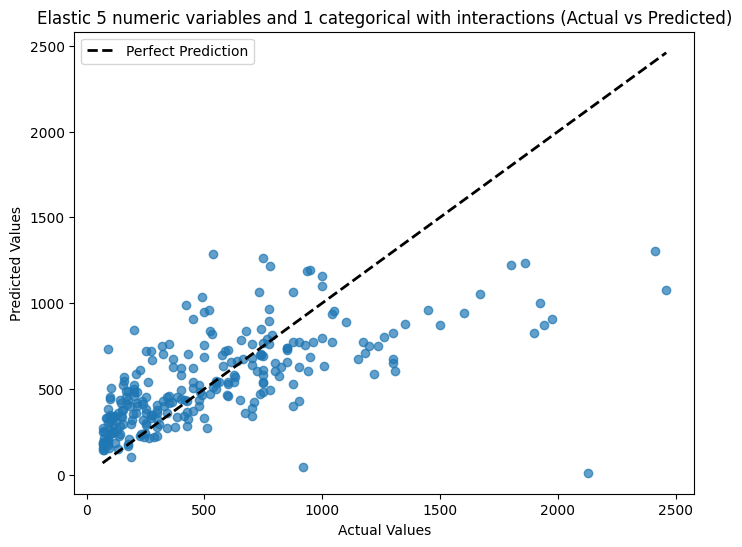

In [40]:
import matplotlib.pyplot as plt
X = data[["Hits","AtBat", "CRuns","CWalks","CHits", "Division"]]
y = data["Salary"]

elas_pipeline = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct_inter),
  ("elastic", ElasticNet(alpha=1, l1_ratio=.2))]
).set_output(transform = "pandas")

elas_fitted = elas_pipeline.fit(X, y)
y_pred= elas_fitted.predict(X)
cross13=cross_val_score(elas_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print("final model mse:",-cross13)

plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Elastic 5 numeric variables and 1 categorical with interactions (Actual vs Predicted)")
plt.legend()
plt.show()

The best model at predicting baseball salaries is an elastic net with the five most important numeric varaibles and the most important categorical variable with interactions. It has the smallest MSE value at 125,270.